# ComplexCNN-FPC Model for GABA-edited MRS
Based on the publication "Frequency and phase correction of GABA-edited magnetic resonance spectroscopy using complex-valued convolutional neural networks" <br>
(doi: 10.1016/j.mri.2024.05.008) by Hanna Bugler, Rodrigo Berto, Roberto Souza and Ashley Harris (2024)

### Getting Started
> - Notebook requires local copies of FPC_Functions.py, ComplexCNN_FPC_freq.pt, and ComplexCNN_FPC_phase.pt <br>
> - Data is assumed to be loaded in the frequency domain (when applicable) <br>
> - Data is assumed to be named after colloquial terms "ppm.npy" (1D vector), "time.npy" (1D vector), "specs_data.npy" (2D matrix: sample # by complex spectral points) <br>
> - User is required to set the folder name containing the above data (dataDir) <br>

In [2]:
# Package Imports
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from FPC_Functions import toFids, toSpecs, normSpecs, getComp, window1024, corrFShift, corrPShift

In [3]:
# ComplexCNN-FPC Model Implementation

class Comp_Conv1d(torch.nn.Module):
    def __init__(self, in_filters, out_filters):
        super(Comp_Conv1d, self).__init__()
        self.convreal = nn.Conv1d(in_channels=in_filters, out_channels=out_filters, kernel_size=(5), padding='same')
        self.convimag = nn.Conv1d(in_channels=in_filters, out_channels=out_filters, kernel_size=(5), padding='same')

    def forward(self, input):  # defines structure
        ureal, uimag = torch.split(input, split_size_or_sections=[int(input.shape[1]/2), int(input.shape[1]/2)], dim=1)
        oreal = self.convreal(ureal) - self.convimag(uimag)
        oimag = self.convimag(ureal) + self.convreal(uimag)
        outFinal = torch.concat((oreal, oimag), dim=1)

        return outFinal

padd, num_InChannels = 'same', 1
numFilts_l1, numFilts_l2 = 8, 16
linFilts_l1, linFilts_l2, linFilts_l3 = 1024, 2048, 4096

class compIn_compConv(nn.Module):
    def __init__(self):
        super(compIn_compConv, self).__init__()
        self.conv1_1 = Comp_Conv1d(in_filters=1, out_filters=8)
        self.conv1_2 = Comp_Conv1d(in_filters=8, out_filters=8)
        self.mp1 = nn.MaxPool1d(kernel_size=(2))

        self.conv2_1 = Comp_Conv1d(in_filters=8, out_filters=16)
        self.conv2_2 = Comp_Conv1d(in_filters=16, out_filters=16)
        self.mp2 = nn.MaxPool2d(kernel_size=(2))

        self.flat1 = nn.Flatten()

        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=1)


    def forward(self, input):  # defines structure
        out = F.relu(self.conv1_1(input))
        out = F.relu(self.conv1_2(out))
        out = self.mp1(out)

        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.mp2(out)

        out = self.flat1(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        outFinal = self.fc3(out)

        return outFinal

class FPC_Dataset_2C(Dataset): 
    def __init__(self, specs):
        self.specs = specs
        self.len = int(self.specs.shape[1])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        indv_specs = self.specs[:, index, :]

        return indv_specs

### Apply FPC to GABA-edited MRS Data with ComplexCNN-FPC

In [ ]:
# User set data location
dataDir = ""

In [4]:
# variables needed to perform FPC
time = np.load(f"{dataDir}time.npy")
ppm = np.load(f"{dataDir}ppm.npy")

########################################################################################################################
# Frequency Correction
########################################################################################################################
# load and process uncorrected specs data
data = np.load(f"{dataDir}specs_data.npy")
data_norm = normSpecs(data)
data_2ChanComp = getComp(data_norm)
data_2ChanCompW = window1024(data_2ChanComp, ppm)

# pass uncorrected specs through frequency correction model
flabels, ind = np.zeros(shape=data.shape[0]), 0
model = compIn_compConv().float()
model.load_state_dict(torch.load(f"{dataDir}ComplexCNN_FPC_freq.pt"))
model.eval()
dataloader_freq = DataLoader(dataset=FPC_Dataset_2C(data_2ChanCompW), batch_size=64, shuffle=False)

with torch.no_grad():
    for specs in dataloader_freq:
        labels = model(specs.float())
        # print(f'intermediary labels are {labels}')
        flabels[ind*labels.shape[0]:(ind+1)*labels.shape[0]] = labels[:,0]
        ind+=1 

# apply frequency corrections
fids = toFids(data, 1)
fids_FC = corrFShift(fids, time, flabels)
specs_FC = toSpecs(fids_FC, 1)

########################################################################################################################
# Phase Correction
########################################################################################################################
# process FC data
data_FCNorm = normSpecs(specs_FC)
data_FC_2ChanComp = getComp(data_FCNorm)
data_FC_2ChanCompW = window1024(data_FC_2ChanComp, ppm)

# pass frequency corrected specs through phase correction model
plabels, ind = np.zeros(shape=data.shape[0]), 0
model = compIn_compConv().float()
model.load_state_dict(torch.load(f"{dataDir}ComplexCNN_FPC_phase.pt"))
model.eval()
dataloader_phase = DataLoader(dataset=FPC_Dataset_2C(data_FC_2ChanCompW), batch_size=64, shuffle=False)

with torch.no_grad():
    for specs in dataloader_phase:
        labels = model(specs.float())
        plabels[ind*labels.shape[0]:(ind+1)*labels.shape[0]] = labels[:,0]
        ind+=1 

# apply phase corrections
fids_FPC = corrPShift(fids_FC, plabels)
specs_FPC = toSpecs(fids_FPC, 1)

# save FPC data
np.save(f"{dataDir}FPC_data.npy", specs_FPC)

### Visualize the FPC GABA-edited MRS Data with ComplexCNN-FPC
> A randomly selected scan is used to review the effect of FPC on the mean spectrum (may require editing to implement specific interleaving scheme) <br>
> Individual FPC transients including the range of the GABA peak are plotted to review the general effect of FPC on a scan <br>
(Example shows FPC performed on simulated SNR 2.5 ON subspectra data with positive residual water peaks)

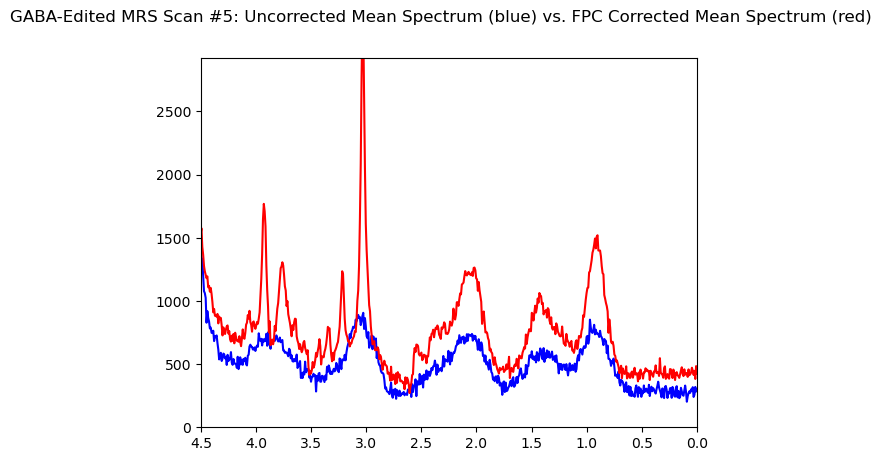

In [5]:
# Data Visualization - Mean Spectrum
numScans = int(data.shape[0]/160)
rndScan = random.randint(0, numScans)

fig0, ax0 = plt.subplots(1)
fig0.suptitle(f"GABA-Edited MRS Scan #{rndScan}: Uncorrected Mean Spectrum (blue) vs. FPC Corrected Mean Spectrum (red)")
ax0.plot(ppm, data[(160*rndScan):(160*(rndScan+1)), :].mean(axis=0).real, 'blue')
ax0.plot(ppm, specs_FPC[(160*rndScan):(160*(rndScan+1)), :].mean(axis=0).real, 'red')
ax0.set_xlim(0, 4.5)
ax0.set_ylim(0, np.max(specs_FPC[(160*rndScan):(160*(rndScan+1)), :1024].real))
ax0.invert_xaxis()
plt.show()

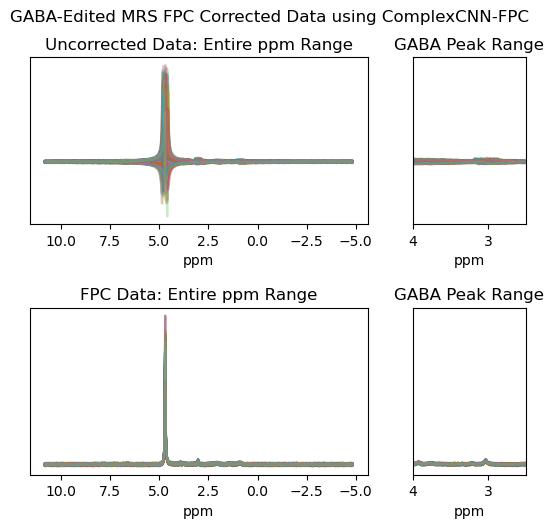

In [7]:
# Data Visualization - Individual Transients
fig1, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [3, 1]})
fig1.suptitle("GABA-Edited MRS FPC Corrected Data using ComplexCNN-FPC")

# Uncorrected Data
# Whole ppm Scale
ax[0,0]. set_title("Uncorrected Data: Entire ppm Range")
for scanN in range(0, data.shape[0]):
    ax[0,0].plot(ppm, data[scanN, :].real, alpha=0.25)
ax[0,0].set_xlabel('ppm')
ax[0,0].get_yaxis().set_visible(False)
ax[0,0].invert_xaxis()

# GABA peak scale
ax[0, 1].set_title("GABA Peak Range")
for scanN in range(0, data.shape[0]):
    ax[0, 1].plot(ppm, data[scanN, :].real, alpha=0.25)
ax[0, 1].set_xlabel('ppm')
ax[0, 1].get_yaxis().set_visible(False)
ax[0, 1].set_xlim(2.5, 4)
ax[0, 1].invert_xaxis()


# Frequency and Phase Corrected Data
# Whole ppm Scale
ax[1,0]. set_title("FPC Data: Entire ppm Range")
for scanN in range(0, data.shape[0]):
    ax[1,0].plot(ppm, specs_FPC[scanN, :].real, alpha=0.25)
ax[1,0].set_xlabel('ppm')
ax[1,0].get_yaxis().set_visible(False)
ax[1,0].invert_xaxis()

# GABA peak scale
ax[1, 1].set_title("GABA Peak Range")
for scanN in range(0, data.shape[0]):
    ax[1, 1].plot(ppm, specs_FPC[scanN, :].real, alpha=0.25)
ax[1, 1].set_xlabel('ppm')
ax[1, 1].get_yaxis().set_visible(False)
ax[1, 1].set_xlim(2.5, 4)
ax[1, 1].invert_xaxis()


plt.subplots_adjust(top = 0.88, bottom=0.01, hspace=0.5, wspace=0.20)
plt.show()